In [1]:
!pip install wget torchinfo

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e1fc184d189541e31046beceb97320165c2c3fdc7cb09e8c14a17d62f447b0ba
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip

!unzip -qq NCT-CRC-HE-100K.zip -d train
!unzip -qq CRC-VAL-HE-7K.zip -d val

print("dataset setup complete!")

--2025-02-23 04:52:20--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-02-23 04:52:20--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  10.89G  24.6MB/s    in 7m 42s  

2025-02-23 05:00:02 (24.1 MB/s) - ‘NCT-CRC-HE-100K.zip’ saved [11690284003/11690284003]

--2025-02-23 05:00:02--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.

In [3]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

from glob import glob
import os
import cv2

In [4]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [5]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [6]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

        self.attention_biases = None
        self.attention_bias_idxs = None

    def compute_attention_bias(self, resolution):

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)

        attention_offsets = {}
        idxs = []

        # if N = 196, then resolution = 14
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        num_offsets = len(attention_offsets)

        # 각 attention head에 대해 num_offsets 만큼의 학습 가능한 Bias를 생성
        self.attention_biases = nn.Parameter(torch.zeros(self.num_heads, num_offsets).to(next(self.parameters()).device))
        self.attention_bias_idxs = torch.LongTensor(idxs).view(N, N).to(next(self.parameters()).device)

    def forward(self, x):
        B, N, C = x.shape
        resolution = int(N ** 0.5)

        if self.attention_biases is None or self.attention_bias_idxs.shape[0] != N:
            self.compute_attention_bias(resolution)

        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: (B, num_heads, N, N)
        attn_bias = self.attention_biases[:, self.attention_bias_idxs].unsqueeze(0) # attn_bias: (1, num_heads, N, N)
        attn = attn + attn_bias
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [8]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [9]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [10]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [11]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [12]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [14]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [15]:
model = LevitDistilled(num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [16]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [17]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [18]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = True  # 연산 속도를 희생하고 일관된 연산을 수행 -> SOTA: True로 변환

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [19]:
train_dir = './train/NCT-CRC-HE-100K'
val_dir = './val/CRC-VAL-HE-7K'

In [20]:
from torch.utils.data import Dataset

# replace global_pool with 'max' to train the second model
GLOBAL_POOL = 'avg'
NUM_CLASSES = 9
BATCH_SIZE = 48


class Dataset(Dataset):
    def __init__(self, dir, aug=False):

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.aug = aug
        self.samples = [i for i in glob(os.path.join(dir, '**/*')) if os.path.isfile(i)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        class_name = os.path.basename(self.samples[idx]).split('-')[0]
        label = {
            'ADI': 0,
            'BACK': 1,
            'DEB': 2,
            'LYM': 3,
            'MUC': 4,
            'MUS': 5,
            'NORM': 6,
            'STR': 7,
            'TUM': 8,
        }

        img = cv2.imread(self.samples[idx], -1)[:, :, ::-1]
        img = np.float32(img) / 255.0

        if self.aug:
            if random.random() < 0.5:
                img = img[::-1]

            if random.random() < 0.5:
                img = img[:, ::-1]

            if random.random() < 0.3:
                if random.random() < 0.5:
                    img += np.random.normal(
                        0.0, np.random.uniform(0.01, 0.2),
                        (img.shape[0], img.shape[1], img.shape[2])
                    )
                else:
                    x = np.random.uniform(0.02, 0.15)
                    img += np.random.uniform(
                        -x, x,
                        (img.shape[0], img.shape[1], img.shape[2])
                    )

            if random.random() < 0.9:
                img += np.random.uniform(-0.15, 0.15, (1, 1, 3))
                img *= np.random.uniform(0.85, 1.15, (1, 1, 3))

            if random.random() < 0.3:
                kX, kY = np.random.randint(0, 4, 2) * 2 + 1
                if random.random() < 0.5:
                    img = cv2.GaussianBlur(img, (kX, kY), 0)
                else:
                    img = cv2.blur(img, (kX, kY))

        img = np.uint8(np.clip(img, 0, 1) * 255.0)
        img = self.transform(Image.fromarray(img))

        return img, label[class_name]

In [21]:
train_dataset = Dataset(dir=train_dir, aug=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=False, drop_last=True)
test_dataset = Dataset(dir=val_dir, aug=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)

In [22]:
num_epochs = 100

In [23]:
optim = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.75, verbose=True)
loss_fn = torch.nn.CrossEntropyLoss()
best_acc = 0.0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [30]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [25]:
for e in range(num_epochs):
        model.train()
        losses = []
        for (img, y_true) in tqdm(train_dataloader):
            y_pred = model(img.to(device))
            loss = loss_fn(y_pred, y_true.to(device))

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.item())

        torch.save(model.state_dict(), f'model_last.pth')

        scheduler.step()
        model.eval()

        targets_array = []
        predictions_array = []
        test_losses = []
        test_accuracies = []
        test_balacc = []

        with torch.no_grad():

            test_iter = iter(test_dataloader)
            for j in range(len(test_dataloader)):

                image, labels = next(test_iter)
                image = image.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                predictions = model(image)

                loss = loss_fn(predictions, labels)
                test_losses.append(loss.item())

                _, predictions = torch.max(predictions.data, 1)

                predictions = predictions.detach().cpu().numpy()
                targets = labels.detach().cpu().numpy()

                for k in range(targets.shape[0]):

                    target = targets[k]
                    predicted = predictions[k]

                    targets_array.append(target)
                    predictions_array.append(predicted)

            acc = accuracy_score(targets_array, predictions_array)
            bacc = balanced_accuracy_score(targets_array, predictions_array)
            test_accuracies.append(acc)
            test_balacc.append(bacc)
            print(f'{e} Epochs')
            print('Train loss: ' + str(np.mean(losses)))
            print('Test loss: ' + str(np.mean(test_losses)))
            print('Accuracy: ' + str(acc))
            print('Balanced Accuracy: ' + str(bacc))

            if best_acc < acc:
                best_acc = acc
                torch.save(model.state_dict(), f'model_best.pth')
                print(f'Best acc saved at {e} epochs')

100%|██████████| 2083/2083 [01:26<00:00, 24.07it/s]


0 Epochs
Train loss: 0.4039716978507779
Test loss: 0.9867011122677483
Accuracy: 0.7193593314763231
Balanced Accuracy: 0.7086021697496191
Best acc saved at 0 epochs


100%|██████████| 2083/2083 [01:25<00:00, 24.33it/s]


1 Epochs
Train loss: 0.16625296993988584
Test loss: 0.7370957725598222
Accuracy: 0.8087743732590529
Balanced Accuracy: 0.7842300570794182
Best acc saved at 1 epochs


100%|██████████| 2083/2083 [01:25<00:00, 24.36it/s]


2 Epochs
Train loss: 0.11813608263304035
Test loss: 0.7571119082719069
Accuracy: 0.8831476323119777
Balanced Accuracy: 0.8488553617767366
Best acc saved at 2 epochs


100%|██████████| 2083/2083 [01:26<00:00, 24.02it/s]


3 Epochs
Train loss: 0.08925861279293269
Test loss: 0.8124988868790751
Accuracy: 0.8424791086350975
Balanced Accuracy: 0.8232262737346447


100%|██████████| 2083/2083 [01:26<00:00, 24.18it/s]


4 Epochs
Train loss: 0.07546998595428665
Test loss: 0.4708609662372328
Accuracy: 0.874233983286908
Balanced Accuracy: 0.8604647195194567


100%|██████████| 2083/2083 [01:26<00:00, 24.06it/s]


5 Epochs
Train loss: 0.048161156241302155
Test loss: 0.5082781146056656
Accuracy: 0.8956824512534819
Balanced Accuracy: 0.8651163186917578
Best acc saved at 5 epochs


100%|██████████| 2083/2083 [01:26<00:00, 23.97it/s]


6 Epochs
Train loss: 0.044381370080748515
Test loss: 0.6007950877030168
Accuracy: 0.9030640668523677
Balanced Accuracy: 0.8710283292707115
Best acc saved at 6 epochs


100%|██████████| 2083/2083 [01:26<00:00, 24.13it/s]


7 Epochs
Train loss: 0.03731744870226817
Test loss: 0.8065939006762991
Accuracy: 0.8474930362116991
Balanced Accuracy: 0.8383320303323548


100%|██████████| 2083/2083 [01:25<00:00, 24.22it/s]


8 Epochs
Train loss: 0.03304400408514308
Test loss: 0.9812009720407499
Accuracy: 0.8146239554317549
Balanced Accuracy: 0.8053903839212281


100%|██████████| 2083/2083 [01:26<00:00, 24.08it/s]


9 Epochs
Train loss: 0.030773388111805397
Test loss: 0.6074832379981591
Accuracy: 0.8871866295264624
Balanced Accuracy: 0.8556062808955724


100%|██████████| 2083/2083 [01:26<00:00, 24.09it/s]


10 Epochs
Train loss: 0.018213038143775805
Test loss: 0.6570512381133746
Accuracy: 0.8896935933147633
Balanced Accuracy: 0.8786389531645699


100%|██████████| 2083/2083 [01:26<00:00, 24.20it/s]


11 Epochs
Train loss: 0.017809738057797394
Test loss: 0.6699732361480092
Accuracy: 0.9055710306406686
Balanced Accuracy: 0.8784422772786097
Best acc saved at 11 epochs


100%|██████████| 2083/2083 [01:25<00:00, 24.39it/s]


12 Epochs
Train loss: 0.016361660018682635
Test loss: 0.8791222077173823
Accuracy: 0.8655988857938719
Balanced Accuracy: 0.8498067943883965


100%|██████████| 2083/2083 [01:25<00:00, 24.48it/s]


13 Epochs
Train loss: 0.01563017898550472
Test loss: 0.5721464204064493
Accuracy: 0.8884401114206129
Balanced Accuracy: 0.8713035550575712


100%|██████████| 2083/2083 [01:25<00:00, 24.30it/s]


14 Epochs
Train loss: 0.014167796800949088
Test loss: 1.185234418130619
Accuracy: 0.8143454038997214
Balanced Accuracy: 0.828486348328601


100%|██████████| 2083/2083 [01:25<00:00, 24.27it/s]


15 Epochs
Train loss: 0.00868225192824697
Test loss: 0.5446826036530547
Accuracy: 0.9047353760445682
Balanced Accuracy: 0.8836003581427414


100%|██████████| 2083/2083 [01:26<00:00, 24.21it/s]


16 Epochs
Train loss: 0.008664890928341865
Test loss: 0.6526679772197723
Accuracy: 0.8933147632311977
Balanced Accuracy: 0.8715148043690962


100%|██████████| 2083/2083 [01:25<00:00, 24.29it/s]


17 Epochs
Train loss: 0.008693531218667101
Test loss: 1.3038102405074425
Accuracy: 0.7888579387186629
Balanced Accuracy: 0.7893454543923852


100%|██████████| 2083/2083 [01:25<00:00, 24.36it/s]


18 Epochs
Train loss: 0.008189426615554893
Test loss: 0.702096756514317
Accuracy: 0.9015320334261838
Balanced Accuracy: 0.8812929198988599


100%|██████████| 2083/2083 [01:25<00:00, 24.35it/s]


19 Epochs
Train loss: 0.008331461730775242
Test loss: 0.989125823745
Accuracy: 0.9034818941504178
Balanced Accuracy: 0.874509463076795


100%|██████████| 2083/2083 [01:25<00:00, 24.29it/s]


20 Epochs
Train loss: 0.004615234659446065
Test loss: 0.9419479504139356
Accuracy: 0.8540389972144847
Balanced Accuracy: 0.8469731128581619


100%|██████████| 2083/2083 [01:25<00:00, 24.31it/s]


21 Epochs
Train loss: 0.004563653429408408
Test loss: 0.7630566970101791
Accuracy: 0.910724233983287
Balanced Accuracy: 0.8849042951820799
Best acc saved at 21 epochs


100%|██████████| 2083/2083 [01:26<00:00, 24.16it/s]


22 Epochs
Train loss: 0.004480328009935754
Test loss: 0.6978304540094299
Accuracy: 0.9218662952646239
Balanced Accuracy: 0.8957595197727435
Best acc saved at 22 epochs


100%|██████████| 2083/2083 [01:25<00:00, 24.36it/s]


23 Epochs
Train loss: 0.004372196152169451
Test loss: 0.7854522441054306
Accuracy: 0.9190807799442897
Balanced Accuracy: 0.8879071582079319


100%|██████████| 2083/2083 [01:25<00:00, 24.33it/s]


24 Epochs
Train loss: 0.004133616127602645
Test loss: 0.6513676705137871
Accuracy: 0.9066852367688022
Balanced Accuracy: 0.8864916078686538


100%|██████████| 2083/2083 [01:25<00:00, 24.34it/s]


25 Epochs
Train loss: 0.0028904028720186568
Test loss: 0.7153508067576331
Accuracy: 0.9215877437325906
Balanced Accuracy: 0.8934676540342734


100%|██████████| 2083/2083 [01:25<00:00, 24.35it/s]


26 Epochs
Train loss: 0.002375876346582014
Test loss: 1.0475827027022995
Accuracy: 0.9146239554317549
Balanced Accuracy: 0.8859831113816954


100%|██████████| 2083/2083 [01:25<00:00, 24.35it/s]


27 Epochs
Train loss: 0.002433673507975397
Test loss: 0.9597969739266167
Accuracy: 0.8984679665738161
Balanced Accuracy: 0.8815128782837495


100%|██████████| 2083/2083 [01:26<00:00, 24.15it/s]


28 Epochs
Train loss: 0.0029328700888498964
Test loss: 0.8664334377527606
Accuracy: 0.9161559888579387
Balanced Accuracy: 0.8862981982314824


100%|██████████| 2083/2083 [01:26<00:00, 24.21it/s]


29 Epochs
Train loss: 0.0030370617598060277
Test loss: 0.6652814508155643
Accuracy: 0.923259052924791
Balanced Accuracy: 0.8997835771876694
Best acc saved at 29 epochs


100%|██████████| 2083/2083 [01:25<00:00, 24.22it/s]


30 Epochs
Train loss: 0.001255799349826799
Test loss: 0.6907186690666552
Accuracy: 0.9079387186629526
Balanced Accuracy: 0.885539509337743


100%|██████████| 2083/2083 [01:25<00:00, 24.24it/s]


31 Epochs
Train loss: 0.001997670275084312
Test loss: 0.7861790692793595
Accuracy: 0.9126740947075209
Balanced Accuracy: 0.8896157941521585


100%|██████████| 2083/2083 [01:27<00:00, 23.94it/s]


32 Epochs
Train loss: 0.001281462538119759
Test loss: 0.9355526605469915
Accuracy: 0.9036211699164345
Balanced Accuracy: 0.8843164305508229


100%|██████████| 2083/2083 [01:25<00:00, 24.26it/s]


33 Epochs
Train loss: 0.0014567835360739098
Test loss: 0.9563591890851033
Accuracy: 0.9167130919220056
Balanced Accuracy: 0.8953556939931588


100%|██████████| 2083/2083 [01:26<00:00, 24.02it/s]


34 Epochs
Train loss: 0.0015278832432048476
Test loss: 1.0375539875235822
Accuracy: 0.9176880222841226
Balanced Accuracy: 0.8914088606416386


100%|██████████| 2083/2083 [01:25<00:00, 24.29it/s]


35 Epochs
Train loss: 0.0010040174414838376
Test loss: 1.014546574019285
Accuracy: 0.9093314763231197
Balanced Accuracy: 0.8854382983400132


100%|██████████| 2083/2083 [01:25<00:00, 24.29it/s]


36 Epochs
Train loss: 0.0012538096477315655
Test loss: 0.921667950398211
Accuracy: 0.9235376044568245
Balanced Accuracy: 0.8982083911873416
Best acc saved at 36 epochs


100%|██████████| 2083/2083 [01:25<00:00, 24.23it/s]


37 Epochs
Train loss: 0.0009038002221468263
Test loss: 0.9576315184165044
Accuracy: 0.9072423398328691
Balanced Accuracy: 0.8862284522928436


100%|██████████| 2083/2083 [01:25<00:00, 24.33it/s]


38 Epochs
Train loss: 0.001170486986499547
Test loss: 0.8888824601403958
Accuracy: 0.9034818941504178
Balanced Accuracy: 0.8870216783389414


100%|██████████| 2083/2083 [01:26<00:00, 24.20it/s]


39 Epochs
Train loss: 0.001038584854816888
Test loss: 0.9945248992943699
Accuracy: 0.9144846796657382
Balanced Accuracy: 0.893764977996423


100%|██████████| 2083/2083 [01:25<00:00, 24.24it/s]


40 Epochs
Train loss: 0.0006497527092963429
Test loss: 1.0213338288954135
Accuracy: 0.8984679665738161
Balanced Accuracy: 0.8762188324011372


100%|██████████| 2083/2083 [01:26<00:00, 24.14it/s]


41 Epochs
Train loss: 0.000587408159070029
Test loss: 1.1145953841787075
Accuracy: 0.8994428969359332
Balanced Accuracy: 0.8808152204209025


100%|██████████| 2083/2083 [01:25<00:00, 24.30it/s]


42 Epochs
Train loss: 0.00045757416476606687
Test loss: 0.9875994507396904
Accuracy: 0.9133704735376045
Balanced Accuracy: 0.8938280565436957


100%|██████████| 2083/2083 [01:26<00:00, 24.20it/s]


43 Epochs
Train loss: 0.0006008254732422791
Test loss: 1.1474579889607766
Accuracy: 0.8934540389972145
Balanced Accuracy: 0.8784934491092582


100%|██████████| 2083/2083 [01:26<00:00, 24.17it/s]


44 Epochs
Train loss: 0.0005035303734891414
Test loss: 0.9785422800401526
Accuracy: 0.906824512534819
Balanced Accuracy: 0.8859860424276331


100%|██████████| 2083/2083 [01:26<00:00, 24.21it/s]


45 Epochs
Train loss: 0.00046238641067836226
Test loss: 0.9892486735246347
Accuracy: 0.89025069637883
Balanced Accuracy: 0.8746321688582278


100%|██████████| 2083/2083 [01:26<00:00, 24.20it/s]


46 Epochs
Train loss: 0.00041902342926764067
Test loss: 1.1489805284639685
Accuracy: 0.9004178272980501
Balanced Accuracy: 0.8751518244358107


100%|██████████| 2083/2083 [01:25<00:00, 24.31it/s]


47 Epochs
Train loss: 0.00037800104159539254
Test loss: 1.1042136344941713
Accuracy: 0.9
Balanced Accuracy: 0.8767441760219696


100%|██████████| 2083/2083 [01:25<00:00, 24.32it/s]


48 Epochs
Train loss: 0.00029860025951825475
Test loss: 1.0781904802231053
Accuracy: 0.9066852367688022
Balanced Accuracy: 0.8800549802906118


100%|██████████| 2083/2083 [01:25<00:00, 24.30it/s]


49 Epochs
Train loss: 0.0005383676048626731
Test loss: 1.1294692949391687
Accuracy: 0.9059888579387186
Balanced Accuracy: 0.8864250360197956


100%|██████████| 2083/2083 [01:26<00:00, 24.19it/s]


50 Epochs
Train loss: 0.0003557232970354417
Test loss: 1.1188089410094022
Accuracy: 0.9171309192200557
Balanced Accuracy: 0.8924504210047607


100%|██████████| 2083/2083 [01:25<00:00, 24.26it/s]


51 Epochs
Train loss: 0.00020783758005749593
Test loss: 0.9591460314890446
Accuracy: 0.9108635097493036
Balanced Accuracy: 0.8876815759128233


100%|██████████| 2083/2083 [01:25<00:00, 24.27it/s]


52 Epochs
Train loss: 0.00021992174191895957
Test loss: 1.0794089595456766
Accuracy: 0.9137883008356545
Balanced Accuracy: 0.8887626202617164


100%|██████████| 2083/2083 [01:26<00:00, 24.21it/s]


53 Epochs
Train loss: 0.00013462522041292495
Test loss: 1.0487046096101562
Accuracy: 0.9129526462395543
Balanced Accuracy: 0.889181202920017


100%|██████████| 2083/2083 [01:25<00:00, 24.45it/s]


54 Epochs
Train loss: 0.00024747495669472764
Test loss: 1.2683475021522583
Accuracy: 0.9082172701949861
Balanced Accuracy: 0.8885639287517884


100%|██████████| 2083/2083 [01:26<00:00, 24.10it/s]


55 Epochs
Train loss: 0.00026473876119283553
Test loss: 1.3533105873256708
Accuracy: 0.908774373259053
Balanced Accuracy: 0.8882329705965661


100%|██████████| 2083/2083 [01:26<00:00, 24.17it/s]


56 Epochs
Train loss: 0.00014236976818378697
Test loss: 1.3608885169686422
Accuracy: 0.8983286908077994
Balanced Accuracy: 0.879092540560545


100%|██████████| 2083/2083 [01:26<00:00, 24.19it/s]


57 Epochs
Train loss: 0.00013315626663445575
Test loss: 1.2832809801794416
Accuracy: 0.9079387186629526
Balanced Accuracy: 0.8845793070979577


100%|██████████| 2083/2083 [01:26<00:00, 24.22it/s]


58 Epochs
Train loss: 0.00018177422619486424
Test loss: 1.2503444653422984
Accuracy: 0.9064066852367688
Balanced Accuracy: 0.8861652555511622


100%|██████████| 2083/2083 [01:26<00:00, 24.20it/s]


59 Epochs
Train loss: 0.0002415377169989347
Test loss: 1.0946410203201604
Accuracy: 0.9115598885793872
Balanced Accuracy: 0.8887124023661322


100%|██████████| 2083/2083 [01:26<00:00, 24.17it/s]


60 Epochs
Train loss: 0.0001492983121885733
Test loss: 1.1659179404018707
Accuracy: 0.9164345403899722
Balanced Accuracy: 0.8928536158226998


100%|██████████| 2083/2083 [01:26<00:00, 24.13it/s]


61 Epochs
Train loss: 0.0001391038403795575
Test loss: 1.1264844178065097
Accuracy: 0.9144846796657382
Balanced Accuracy: 0.8904224315833097


100%|██████████| 2083/2083 [01:26<00:00, 24.13it/s]


62 Epochs
Train loss: 9.880628689562105e-05
Test loss: 1.1094528993140789
Accuracy: 0.9155988857938718
Balanced Accuracy: 0.8903568860400414


100%|██████████| 2083/2083 [01:26<00:00, 24.13it/s]


63 Epochs
Train loss: 0.0001124970282142349
Test loss: 1.0234156369156329
Accuracy: 0.9132311977715878
Balanced Accuracy: 0.890501616311307


100%|██████████| 2083/2083 [01:25<00:00, 24.23it/s]


64 Epochs
Train loss: 0.00017475130415555402
Test loss: 1.1046341159490416
Accuracy: 0.918941504178273
Balanced Accuracy: 0.8957196584247836


100%|██████████| 2083/2083 [01:26<00:00, 24.07it/s]


65 Epochs
Train loss: 8.702649390890057e-05
Test loss: 1.0713302493238568
Accuracy: 0.9115598885793872
Balanced Accuracy: 0.8892070433861888


100%|██████████| 2083/2083 [01:26<00:00, 24.19it/s]


66 Epochs
Train loss: 8.522640804628307e-05
Test loss: 1.2225167395134016
Accuracy: 0.908774373259053
Balanced Accuracy: 0.8857261502628231


100%|██████████| 2083/2083 [01:25<00:00, 24.25it/s]


67 Epochs
Train loss: 0.00012528927403601095
Test loss: 1.175931847183288
Accuracy: 0.9142061281337047
Balanced Accuracy: 0.8895457174222153


100%|██████████| 2083/2083 [01:25<00:00, 24.25it/s]


68 Epochs
Train loss: 9.557352308001241e-05
Test loss: 1.1207087408763565
Accuracy: 0.9139275766016713
Balanced Accuracy: 0.8894541848563475


100%|██████████| 2083/2083 [01:26<00:00, 24.15it/s]


69 Epochs
Train loss: 9.938030853521536e-05
Test loss: 1.183627334530084
Accuracy: 0.9123955431754874
Balanced Accuracy: 0.8883052862834611


100%|██████████| 2083/2083 [01:26<00:00, 24.19it/s]


70 Epochs
Train loss: 5.748822213883104e-05
Test loss: 1.0513801759766042
Accuracy: 0.9185236768802229
Balanced Accuracy: 0.8943723418728479


100%|██████████| 2083/2083 [01:26<00:00, 24.20it/s]


71 Epochs
Train loss: 0.00010322077950475548
Test loss: 1.212301819955005
Accuracy: 0.906824512534819
Balanced Accuracy: 0.8846143500698546


100%|██████████| 2083/2083 [01:26<00:00, 24.09it/s]


72 Epochs
Train loss: 7.972637166278666e-05
Test loss: 1.2494788248015996
Accuracy: 0.910724233983287
Balanced Accuracy: 0.8881186000581539


100%|██████████| 2083/2083 [01:25<00:00, 24.25it/s]


73 Epochs
Train loss: 8.970330806105344e-05
Test loss: 1.0389970357701133
Accuracy: 0.9123955431754874
Balanced Accuracy: 0.893184969080183


100%|██████████| 2083/2083 [01:26<00:00, 24.16it/s]


74 Epochs
Train loss: 0.00011173490140223157
Test loss: 1.3128241421791305
Accuracy: 0.9073816155988857
Balanced Accuracy: 0.8875791546227932


100%|██████████| 2083/2083 [01:26<00:00, 24.00it/s]


75 Epochs
Train loss: 3.612081391300588e-05
Test loss: 1.2046693388875838
Accuracy: 0.9175487465181058
Balanced Accuracy: 0.8936321262355439


100%|██████████| 2083/2083 [01:26<00:00, 24.10it/s]


76 Epochs
Train loss: 5.324137773693852e-05
Test loss: 1.108782998961546
Accuracy: 0.9066852367688022
Balanced Accuracy: 0.88558340199701


100%|██████████| 2083/2083 [01:25<00:00, 24.25it/s]


77 Epochs
Train loss: 7.210173176061417e-05
Test loss: 1.1635604381828064
Accuracy: 0.9155988857938718
Balanced Accuracy: 0.8917983823765768


100%|██████████| 2083/2083 [01:26<00:00, 24.16it/s]


78 Epochs
Train loss: 6.172942081878977e-05
Test loss: 1.1691265679880969
Accuracy: 0.9128133704735376
Balanced Accuracy: 0.8885693824093938


100%|██████████| 2083/2083 [01:25<00:00, 24.25it/s]


79 Epochs
Train loss: 6.331183621016096e-05
Test loss: 1.2618225377888754
Accuracy: 0.9181058495821727
Balanced Accuracy: 0.8935873707993801


100%|██████████| 2083/2083 [01:26<00:00, 24.11it/s]


80 Epochs
Train loss: 3.05679884297315e-05
Test loss: 1.186636322012556
Accuracy: 0.910724233983287
Balanced Accuracy: 0.8880999432444672


100%|██████████| 2083/2083 [01:25<00:00, 24.24it/s]


81 Epochs
Train loss: 6.452658951334484e-05
Test loss: 1.2327020248264395
Accuracy: 0.914066852367688
Balanced Accuracy: 0.8925520557041335


100%|██████████| 2083/2083 [01:26<00:00, 24.13it/s]


82 Epochs
Train loss: 5.764567137070304e-05
Test loss: 1.258531166087068
Accuracy: 0.9098885793871866
Balanced Accuracy: 0.8873654763124565


100%|██████████| 2083/2083 [01:26<00:00, 24.17it/s]


83 Epochs
Train loss: 5.681467385047633e-05
Test loss: 1.2287744629376927
Accuracy: 0.9083565459610028
Balanced Accuracy: 0.8885985993215334


100%|██████████| 2083/2083 [01:26<00:00, 24.13it/s]


84 Epochs
Train loss: 2.1428108792266234e-05
Test loss: 1.266988936707385
Accuracy: 0.9174094707520891
Balanced Accuracy: 0.8941181492869421


100%|██████████| 2083/2083 [01:26<00:00, 24.12it/s]


85 Epochs
Train loss: 4.4298711540460214e-05
Test loss: 1.2695167667022496
Accuracy: 0.9065459610027855
Balanced Accuracy: 0.8864905086558746


100%|██████████| 2083/2083 [01:25<00:00, 24.26it/s]


86 Epochs
Train loss: 4.42037323534498e-05
Test loss: 1.2244388997900881
Accuracy: 0.9118384401114206
Balanced Accuracy: 0.8909304709960415


100%|██████████| 2083/2083 [01:25<00:00, 24.26it/s]


87 Epochs
Train loss: 5.9402670704338224e-05
Test loss: 1.2349476630419873
Accuracy: 0.9082172701949861
Balanced Accuracy: 0.8890924938645338


100%|██████████| 2083/2083 [01:26<00:00, 24.16it/s]


88 Epochs
Train loss: 0.00010462853966290298
Test loss: 1.3099703955850033
Accuracy: 0.9114206128133705
Balanced Accuracy: 0.8881750202461718


100%|██████████| 2083/2083 [01:25<00:00, 24.26it/s]


89 Epochs
Train loss: 3.407314382108567e-05
Test loss: 1.2370884492210288
Accuracy: 0.9171309192200557
Balanced Accuracy: 0.8924969011306305


100%|██████████| 2083/2083 [01:26<00:00, 24.16it/s]


90 Epochs
Train loss: 4.6962916196827046e-05
Test loss: 1.0871487697081383
Accuracy: 0.9119777158774374
Balanced Accuracy: 0.8918297825345276


100%|██████████| 2083/2083 [01:26<00:00, 24.10it/s]


91 Epochs
Train loss: 3.9140740193123545e-05
Test loss: 1.1902099997650815
Accuracy: 0.9129526462395543
Balanced Accuracy: 0.8900233228473771


100%|██████████| 2083/2083 [01:26<00:00, 24.12it/s]


92 Epochs
Train loss: 0.00010078095877269507
Test loss: 1.2489501845389341
Accuracy: 0.9114206128133705
Balanced Accuracy: 0.8901430048566845


100%|██████████| 2083/2083 [01:26<00:00, 24.21it/s]


93 Epochs
Train loss: 2.3061600284278073e-05
Test loss: 1.1059842524836108
Accuracy: 0.9146239554317549
Balanced Accuracy: 0.892865512844875


100%|██████████| 2083/2083 [01:26<00:00, 24.18it/s]


94 Epochs
Train loss: 3.958261119929196e-05
Test loss: 1.2674132634540758
Accuracy: 0.9178272980501393
Balanced Accuracy: 0.8926106756196247


100%|██████████| 2083/2083 [01:26<00:00, 24.07it/s]


95 Epochs
Train loss: 5.8058347012485186e-05
Test loss: 1.2686149328880165
Accuracy: 0.9114206128133705
Balanced Accuracy: 0.8895976152886268


100%|██████████| 2083/2083 [01:26<00:00, 24.11it/s]


96 Epochs
Train loss: 3.9197887322485817e-05
Test loss: 1.147359273130174
Accuracy: 0.9174094707520891
Balanced Accuracy: 0.8952635444957165


100%|██████████| 2083/2083 [01:25<00:00, 24.25it/s]


97 Epochs
Train loss: 0.0001019576117824877
Test loss: 1.2485485114032708
Accuracy: 0.913091922005571
Balanced Accuracy: 0.8907339070594497


100%|██████████| 2083/2083 [01:25<00:00, 24.22it/s]


98 Epochs
Train loss: 4.04389146578904e-05
Test loss: 1.1880077719368183
Accuracy: 0.9153203342618385
Balanced Accuracy: 0.8927138696631349


100%|██████████| 2083/2083 [01:26<00:00, 24.14it/s]


99 Epochs
Train loss: 2.006239478310936e-05
Test loss: 1.1680602614452988
Accuracy: 0.9135097493036212
Balanced Accuracy: 0.8912298488244669


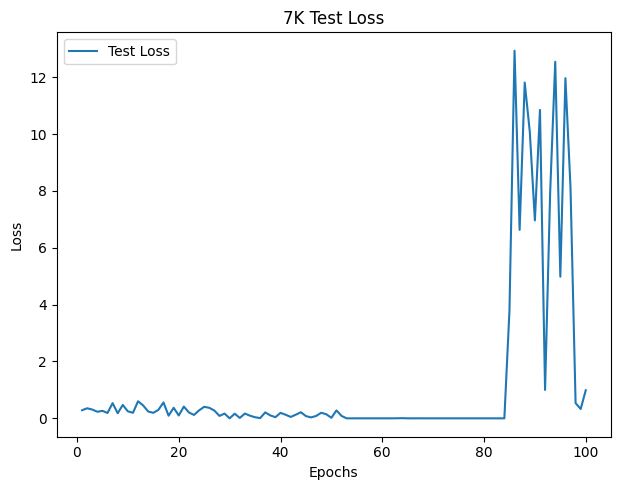

In [28]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, test_losses[:num_epochs], label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("7K Test Loss")
plt.legend()

plt.tight_layout()
plt.show()

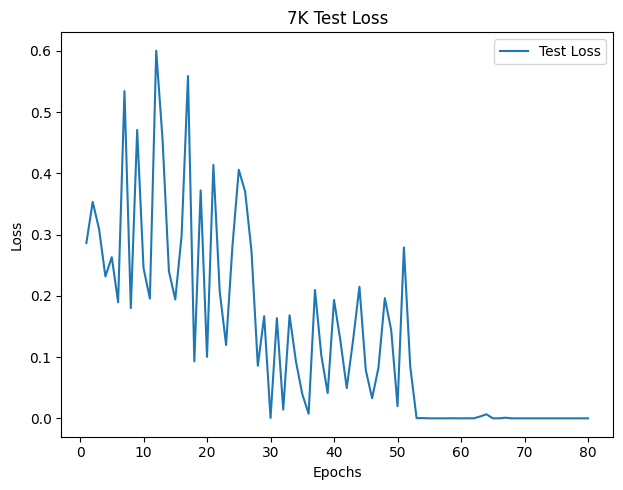

In [33]:
# Plot the metrics
epochs = range(1, 81)

plt.figure(figsize=(12, 5))

# Plot test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, test_losses[:80], label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("7K Test Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
times = measure_inference_time(model, test_dataloader, device)

Inference Time Measurement Results:
Total Inferences: 150
Average Time: 7.55 ms
Standard Deviation: 1.49 ms
Maximum Time: 11.71 ms
Minimum Time: 5.97 ms


In [40]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.11%     191.074us        22.27%       2.016ms      84.012us       0.000us         0.00%       2.549ms     106.190us            24  
                                           aten::linear         0.91%      82.139us        14.55%       1.318ms      73.217us       0.000us         0.00%       1.836ms     102.014us            18  
         

In [41]:
model.load_state_dict(torch.load("model_best.pth"))

<ipython-input-41-573563076d71>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_best.pth"))


<All keys matched successfully>

In [45]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    val_losses = []
    val_accuracies = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [46]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [47]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_dataloader, loss_fn, device, phase="Test")

Test: 100%|██████████| 150/150 [00:04<00:00, 30.59it/s]


Test Loss: 0.9217, Test Accuracy: 92.35%
Overall - F1: 0.8947, Recall: 0.8982, Precision: 0.8964
Per-Class Metrics:
Class 0 - F1: 0.9758, Recall: 0.9641, Precision: 0.9877
Class 1 - F1: 0.9517, Recall: 1.0000, Precision: 0.9078
Class 2 - F1: 0.8886, Recall: 0.9646, Precision: 0.8237
Class 3 - F1: 0.9693, Recall: 0.9953, Precision: 0.9446
Class 4 - F1: 0.9677, Recall: 0.9411, Precision: 0.9959
Class 5 - F1: 0.7772, Recall: 0.7956, Precision: 0.7597
Class 6 - F1: 0.9083, Recall: 0.8623, Precision: 0.9595
Class 7 - F1: 0.6551, Recall: 0.5819, Precision: 0.7492
Class 8 - F1: 0.9587, Recall: 0.9789, Precision: 0.9393


<Figure size 2000x1200 with 0 Axes>

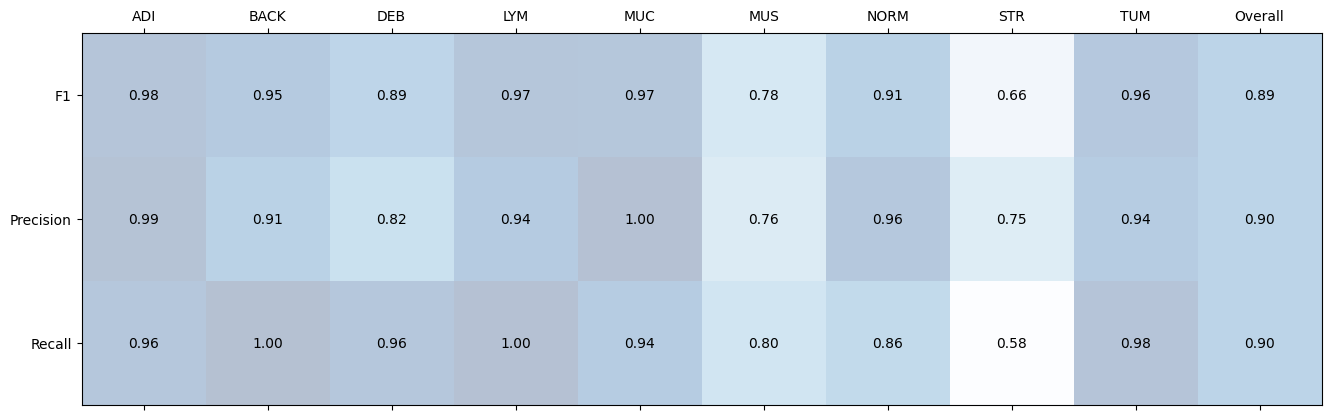

In [48]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [49]:
# prompt: download the last best pth file to local

from google.colab import files
files.download('model_best.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>